In [1]:
import os
import umap
import torch
import itertools
from core import *
import numpy as np
import pandas as pd
import pickle as pkl
from torch import nn
import os.path as op
from tqdm import tqdm
from time import time
from copy import deepcopy
from torch.optim import Adam
from tpot import TPOTRegressor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from capsules.capsules import *
from IPython.display import Image
from qhoptim.pyt import QHM, QHAdam
from matplotlib.lines import Line2D
from torch.autograd import Variable
from matplotlib.patches import Patch
from scipy.stats import spearmanr, pearsonr
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, recall_score

/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

In [3]:
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.models import ApproximateGP, ExactGP 
from sklearn.metrics import accuracy_score
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel, GridInterpolationKernel
from gpytorch.mlls import VariationalELBO, VariationalELBOEmpirical, DeepApproximateMLL
from gpytorch.distributions import MultivariateNormal
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP

In [4]:
np.random.seed(1489)
torch.manual_seed(1489)
torch.cuda.manual_seed(1489)

In [5]:
deepCRISPRPATH = "/home/bakirillov/HDD/data/CRISPR-CAD/DeepCRISPR"

In [6]:
hct116 = pd.read_excel(op.join(deepCRISPRPATH, "13059_2018_1459_MOESM5_ESM.xlsx"), 0)
hek293t = pd.read_excel(op.join(deepCRISPRPATH, "13059_2018_1459_MOESM5_ESM.xlsx"), 1)
hela = pd.read_excel(op.join(deepCRISPRPATH, "13059_2018_1459_MOESM5_ESM.xlsx"), 2)
hl60 = pd.read_excel(op.join(deepCRISPRPATH, "13059_2018_1459_MOESM5_ESM.xlsx"), 3)

In [7]:
hl60_not_in_hct116 = np.logical_not(hl60["sgRNA"].isin(hct116["sgRNA"])).values
hl60_not_in_hek293t = np.logical_not(hl60["sgRNA"].isin(hek293t["sgRNA"])).values
hl60_not_in_hela = np.logical_not(hl60["sgRNA"].isin(hela["sgRNA"])).values

In [8]:
hela_not_in_hct116 = np.logical_not(hela["sgRNA"].isin(hct116["sgRNA"])).values
hela_not_in_hek293t = np.logical_not(hela["sgRNA"].isin(hek293t["sgRNA"])).values
hela_not_in_hl60 = np.logical_not(hela["sgRNA"].isin(hl60["sgRNA"])).values

In [9]:
hct116_not_in_hela = np.logical_not(hct116["sgRNA"].isin(hela["sgRNA"])).values
hct116_not_in_hek293t = np.logical_not(hct116["sgRNA"].isin(hek293t["sgRNA"])).values
hct116_not_in_hl60 = np.logical_not(hct116["sgRNA"].isin(hl60["sgRNA"])).values

In [10]:
hek293t_not_in_hela = np.logical_not(hek293t["sgRNA"].isin(hela["sgRNA"])).values
hek293t_not_in_hct116 = np.logical_not(hek293t["sgRNA"].isin(hct116["sgRNA"])).values
hek293t_not_in_hl60 = np.logical_not(hek293t["sgRNA"].isin(hl60["sgRNA"])).values

In [11]:
hct116.shape, hela.shape, hek293t.shape, hl60.shape

((4239, 6), (8101, 6), (2333, 6), (2076, 6))

In [13]:
hct116.shape[0]+hek293t.shape[0]+hl60.shape[0]

8648

In [12]:
hct116 = hct116[np.logical_and(hct116_not_in_hek293t, hct116_not_in_hl60, hct116_not_in_hela)]
hela = hela[np.logical_and(hela_not_in_hek293t, hela_not_in_hl60, hela_not_in_hct116)]
hl60 = hl60[np.logical_and(hl60_not_in_hek293t, hl60_not_in_hct116, hl60_not_in_hela)]
hek293t = hek293t[np.logical_and(hek293t_not_in_hct116, hek293t_not_in_hela, hek293t_not_in_hl60)]

In [13]:
hct116.shape, hela.shape, hek293t.shape, hl60.shape

((4172, 6), (7998, 6), (2333, 6), (2009, 6))

In [14]:
class GaussianProcessLayer(DeepGPLayer):
    
    def __init__(self, input_dims, output_dims, num_inducing=128, mean_type="constant"):
        if output_dims is None:
            inducing_points = torch.randn(num_inducing, input_dims)
            batch_shape = torch.Size([])
        else:
            inducing_points = torch.randn(output_dims, num_inducing, input_dims)
            batch_shape = torch.Size([output_dims])
        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )
        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )
        super().__init__(variational_strategy, input_dims, output_dims)
        if mean_type == 'constant':
            self.mean_module = ConstantMean(batch_shape=batch_shape)
        else:
            self.mean_module = LinearMean(input_dims)
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=batch_shape, ard_num_dims=input_dims),
            batch_shape=batch_shape, ard_num_dims=None
        )
        
    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return(MultivariateNormal(mean, covar))

In [15]:
class DKL(DeepGP):
    
    def __init__(self, encoder, train_x_shape):
        super(DKL, self).__init__()
        hidden_layer = GaussianProcessLayer(
            input_dims=train_x_shape[-1],
            output_dims=2,
            mean_type='linear',
        )
        last_layer = GaussianProcessLayer(
            input_dims=hidden_layer.output_dims,
            output_dims=None,
            mean_type='constant',
        )
        super().__init__()
        self.FE = encoder
        self.hidden_layer = hidden_layer
        self.last_layer = last_layer
        self.likelihood = GaussianLikelihood()
    
    def forward(self, x):
        internal, rec, _, _, _ = self.FE(x)
        hidden_rep1 = self.hidden_layer(internal.reshape(x.shape[0], -1))#x.reshape(x.shape[0], -1))
        output = self.last_layer(hidden_rep1)
        return(output, rec)

In [16]:
class DeepHFDataset(Dataset):
    
    def __init__(
        self, dataframe, indices, transform=None,
        sequence_column="sgRNA", label_column="Normalized efficacy", labelling="Smart"
    ):
        self.transform = transform
        self.S = dataframe.iloc[indices]
        self.sequence_column = sequence_column
        self.label_column = label_column
        self.labelling = labelling
        
    def __len__(self):
        return(self.S.shape[0])
    
    def __getitem__(self, ind):
        target=self.S.iloc[ind][self.label_column]
        sequence=self.S.iloc[ind][self.sequence_column]
        transformed = self.transform(sequence)
        return(transformed, target)

In [17]:
u = OneHotAndCut("NGG", False, True)

In [18]:
transformer = transforms.Compose(
    [
        u, ToTensor(True)
    ]
)

In [19]:
train_X_hela, test_X_hela, _, _ = train_test_split(
    np.arange(hct116.shape[0]+hek293t.shape[0]+hl60.shape[0]), 
    np.arange(hct116.shape[0]+hek293t.shape[0]+hl60.shape[0]), 
    test_size=0.3
)
train_X_hct116, test_X_hct116, _, _ = train_test_split(
    np.arange(hela.shape[0]+hek293t.shape[0]+hl60.shape[0]), 
    np.arange(hela.shape[0]+hek293t.shape[0]+hl60.shape[0]), 
    test_size=0.3
)
train_X_hek293t, test_X_hek293t, _, _ = train_test_split(
    np.arange(hct116.shape[0]+hela.shape[0]+hl60.shape[0]), 
    np.arange(hct116.shape[0]+hela.shape[0]+hl60.shape[0]), 
    test_size=0.3
)
train_X_hl60, test_X_hl60, _, _ = train_test_split(
    np.arange(hct116.shape[0]+hek293t.shape[0]+hela.shape[0]), 
    np.arange(hct116.shape[0]+hek293t.shape[0]+hela.shape[0]), 
    test_size=0.3
)

In [20]:
hela_ = pd.concat([hct116, hek293t, hl60])
hct116_ = pd.concat([hela, hek293t, hl60])
hek293t_ = pd.concat([hct116, hela, hl60])
hl60_ = pd.concat([hct116, hek293t, hela])

In [21]:
N_CLASSES = 5

In [22]:
hela_train = DeepHFDataset(
    hela_, train_X_hela, transform=transformer
)
hela_test = DeepHFDataset(
    hela_, test_X_hela, transform=transformer#, n_classes=N_CLASSES
)
hct116_train = DeepHFDataset(
    hct116_, train_X_hct116, transform=transformer#, n_classes=N_CLASSES
)
hct116_test = DeepHFDataset(
    hct116_, test_X_hct116, transform=transformer#, n_classes=N_CLASSES
)
hek293t_train = DeepHFDataset(
    hek293t_, train_X_hek293t, transform=transformer#, n_classes=N_CLASSES
)
hek293t_test = DeepHFDataset(
    hek293t_, test_X_hek293t, transform=transformer#, n_classes=N_CLASSES
)
hl60_train = DeepHFDataset(
    hl60_, train_X_hl60, transform=transformer#, n_classes=N_CLASSES
)
hl60_test = DeepHFDataset(
    hl60_, test_X_hl60, transform=transformer#, n_classes=N_CLASSES
)

In [23]:
hela_val = DeepHFDataset(
    hela, np.arange(hela.shape[0]), transform=transformer#, n_classes=N_CLASSES
)
hct116_val = DeepHFDataset(
    hct116, np.arange(hct116.shape[0]), transform=transformer#, n_classes=N_CLASSES
)
hek293t_val = DeepHFDataset(
    hek293t, np.arange(hek293t.shape[0]), transform=transformer#, n_classes=N_CLASSES
)
hl60_val = DeepHFDataset(
    hl60, np.arange(hl60.shape[0]), transform=transformer#, n_classes=N_CLASSES
)

In [24]:
BATCH_SIZE = 64

In [25]:
hela_train_loader = DataLoader(hela_train, shuffle=True, batch_size=BATCH_SIZE)
hela_test_loader = DataLoader(hela_test, shuffle=True, batch_size=BATCH_SIZE)
hek293t_train_loader = DataLoader(hek293t_test, shuffle=True, batch_size=BATCH_SIZE)
hek293t_test_loader = DataLoader(hek293t_test, shuffle=True, batch_size=BATCH_SIZE)
hct116_train_loader = DataLoader(hct116_train, shuffle=True, batch_size=BATCH_SIZE)
hct116_test_loader = DataLoader(hct116_test, shuffle=True, batch_size=BATCH_SIZE)
hl60_train_loader = DataLoader(hl60_train, shuffle=True, batch_size=BATCH_SIZE)
hl60_test_loader = DataLoader(hl60_test, shuffle=True, batch_size=BATCH_SIZE)

In [26]:
hela_val_loader = DataLoader(hela_val, shuffle=True, batch_size=BATCH_SIZE)
hek293t_val_loader = DataLoader(hek293t_val, shuffle=True, batch_size=BATCH_SIZE)
hct116_val_loader = DataLoader(hct116_val, shuffle=True, batch_size=BATCH_SIZE)
hl60_val_loader = DataLoader(hl60_val, shuffle=True, batch_size=BATCH_SIZE)

In [27]:
hela_val[0][0].cpu().data.numpy().shape

(4, 21)

In [28]:
hela_val[0][1]

0.177011494253292

### Classification training on hela

In [29]:
TRAINED = "/home/bakirillov/HDD/weights/CRISPR-CAD/on-target/DeepCRISPR/hela"

In [30]:
if not op.exists(TRAINED):
    os.makedirs(TRAINED)

In [31]:
EPOCHS = 10

In [32]:
training = {"loss": [], "mll": [], "rec": [], "mse": []}
testing = {"loss": [], "mll": [], "rec": [], "mse": []}
validation = {"loss": [], "mll": [], "rec": [], "mse": []}

In [33]:
hela_encoder = GuideCaps(21, 256, 5).cuda()

In [34]:
#hela_encoder = GuideHN(21, 32, n_routes=1360, n_classes=N_CLASSES).cuda()
#hela_encoder = torch.load("/home/bakirillov/HDD/weights/CRISPR-CAD/on-target/DeepCRISPR/chrs/199.ptch")
hela_model = DKL(hela_encoder, [1,5*32]).cuda()

In [35]:
optimizer = Adam([
    {'params': hela_model.parameters()}
], lr=0.05)
mll = DeepApproximateMLL(VariationalELBOEmpirical(hela_model.likelihood, hela_model, 256))

In [36]:
rec_loss = nn.MSELoss(reduction="none")

In [37]:
ALPHA = 10**-5

In [38]:
for a in tqdm(np.arange(EPOCHS)):
    running_loss = []
    running_mll = []
    running_rec = []
    running_targets = []
    running_preds = []
    hela_model.train()
    for i,b in enumerate(hela_train_loader):
        sequence, target = b
        running_targets.append(target.data.numpy())
        optimizer.zero_grad()
        output, reconstruction = hela_model.forward(sequence)
        cmll = -mll(output, target.cuda())
        rcls = rec_loss(reconstruction, sequence.reshape(sequence.shape[0], -1)).sum(1).mean()
        loss = cmll + ALPHA*rcls
        loss.backward()
        optimizer.step()
        predictions = hela_model.likelihood(output).mean.mean(0).cpu().data.numpy()
        running_preds.append(predictions)
        running_loss.append(loss.cpu().data.numpy())
        running_mll.append(cmll.cpu().data.numpy())
        running_rec.append(rcls.cpu().data.numpy())
    training["loss"].append(np.mean(running_loss))
    training["mse"].append(
        mean_squared_error(np.concatenate(running_preds), np.concatenate(running_targets))
    )
    training["mll"].append(np.mean(running_mll))
    training["rec"].append(np.mean(running_rec))
    running_loss = []
    running_mll = []
    running_rec = []
    running_targets = []
    running_preds = []
    hela_model.eval()
    for i,b in enumerate(hela_test_loader):
        sequence, target = b
        running_targets.append(target.data.numpy())
        output, reconstruction = hela_model.forward(sequence)
        cmll = -mll(output, target.cuda())
        rcls = rec_loss(reconstruction, sequence.reshape(sequence.shape[0], -1)).sum(1).mean()
        loss = cmll + ALPHA*rcls
        predictions = hela_model.likelihood(output).mean.mean(0).cpu().data.numpy()
        running_preds.append(predictions)
        running_loss.append(loss.cpu().data.numpy())
        running_mll.append(cmll.cpu().data.numpy())
        running_rec.append(rcls.cpu().data.numpy())
    testing["loss"].append(np.mean(running_loss))
    testing["mse"].append(
        mean_squared_error(np.concatenate(running_preds), np.concatenate(running_targets))
    )
    testing["mll"].append(np.mean(running_mll))
    testing["rec"].append(np.mean(running_rec))
    running_loss = []
    running_mll = []
    running_rec = []
    running_targets = []
    running_preds = []
    for i,b in enumerate(hela_val_loader):
        sequence, target = b
        running_targets.append(target.data.numpy())
        output, reconstruction = hela_model.forward(sequence)
        cmll = -mll(output, target.cuda())
        rcls = rec_loss(reconstruction, sequence.reshape(sequence.shape[0], -1)).sum(1).mean()
        loss = cmll + ALPHA*rcls
        predictions = hela_model.likelihood(output).mean.mean(0).cpu().data.numpy()
        running_preds.append(predictions)
        running_loss.append(loss.cpu().data.numpy())
        running_mll.append(cmll.cpu().data.numpy())
        running_rec.append(rcls.cpu().data.numpy())
    validation["loss"].append(np.mean(running_loss))
    validation["mse"].append(
        mean_squared_error(np.concatenate(running_preds), np.concatenate(running_targets))
    )
    validation["mll"].append(np.mean(running_mll))
    validation["rec"].append(np.mean(running_rec))

100%|██████████| 10/10 [05:42<00:00, 34.22s/it]


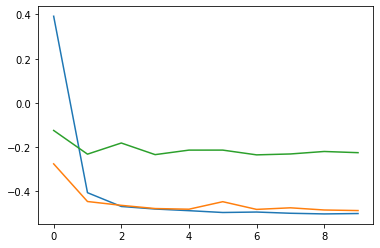

In [39]:
plt.plot(training["loss"])
plt.plot(testing["loss"])
plt.plot(validation["loss"])

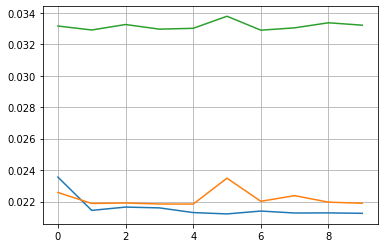

In [40]:
plt.plot(training["mse"])
plt.plot(testing["mse"])
plt.plot(validation["mse"])
plt.grid(True)

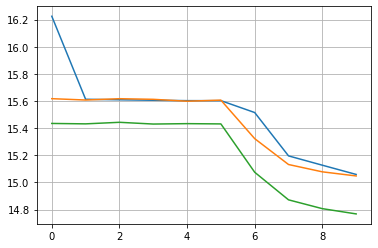

In [41]:
plt.plot(training["rec"])
plt.plot(testing["rec"])
plt.plot(validation["rec"])
plt.grid(True)

In [ ]:
torch.save(hela_model.state_dict(), "hela_model_gp.ptch")

In [42]:
val_predictions = []
val_variances = []
val_targets = []
val_reconstructions = []
for i,b in tqdm(enumerate(hela_val_loader)):
    sequence, target = b
    val_targets.append(target)
    internal, reconstruction = hela_model.forward(sequence)
    prediction = hela_model.likelihood(
        internal
    ).mean.mean(0).cpu().data.numpy()
    variance = hela_model.likelihood(
        internal
    ).variance.mean(0).cpu().data.numpy()
    val_predictions.append(prediction)
    val_reconstructions.append(reconstruction.cpu().data.numpy())
    val_variances.append(variance)
val_predictions = np.concatenate(val_predictions).squeeze()
val_targets = np.concatenate(val_targets)
val_variances = np.concatenate(val_variances)
#val_reconstructions = np.stack(val_reconstructions).squeeze()

125it [00:11, 10.77it/s]


In [43]:
spearmanr(
    val_predictions,
    val_targets
)

/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


SpearmanrResult(correlation=nan, pvalue=nan)

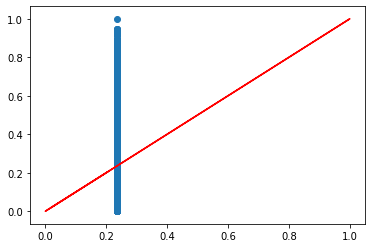

In [44]:
plt.scatter(
    val_predictions,
    val_targets
)
plt.plot(val_targets, val_targets, color="red")

In [ ]:
plt.hist(val_variances, bins=100)
plt.show()

In [ ]:
train_predictions = []
train_variances = []
train_targets = []
train_reconstructions = []
for i,b in tqdm(enumerate(hela_train_loader)):
    sequence, target = b
    train_targets.append(target)
    internal, reconstruction = hela_model.forward(sequence)
    prediction = hela_model.likelihood(
        internal
    ).mean.mean(0).cpu().data.numpy()
    variance = hela_model.likelihood(
        internal
    ).variance.mean(0).cpu().data.numpy()
    train_predictions.append(prediction)
    train_reconstructions.append(reconstruction.cpu().data.numpy())
    train_variances.append(variance)
train_predictions = np.concatenate(train_predictions).squeeze()
train_targets = np.concatenate(train_targets)
train_variances = np.concatenate(train_variances)
#val_reconstructions = np.stack(val_reconstructions).squeeze()

In [ ]:
cat = CatBoostRegressor(loss_function="RMSE", verbose=True)

In [ ]:
train_metrics = np.concatenate([train_predictions.reshape(-1,1), train_variances.reshape(-1,1)], 1)

In [ ]:
val_metrics = np.concatenate([val_predictions.reshape(-1,1), val_variances.reshape(-1,1)], 1)

In [ ]:
train_predictions.shape

In [ ]:
train_variances.shape

In [ ]:
train_metrics.shape

In [ ]:
cat.fit(
    train_metrics, train_targets
)

In [ ]:
spearmanr(
    cat.predict(val_metrics),
    val_targets
)

In [ ]:
plt.scatter(
    cat.predict(val_metrics),
    val_targets
)
plt.plot(val_targets, val_targets, color="red")

In [ ]:
tpot.export("tpot_over_hitnet_deepCRISPR_hela.py")

In [ ]:
from autoPyTorch import AutoNetRegression

In [ ]:
import sklearn.metrics as met

In [ ]:
automl = autosklearn.regression.AutoSklearnRegressor(
    tmp_folder='./tmp/autosklearn_regression_example_tmp',
    output_folder='./tmp/autosklearn_regression_example_out',
)

In [ ]:
automl.fit(
    X=hela_train_internals, 
    y=hela_train_targets, 
    X_test=hela_val_internals, y_test=hela_val_targets,
    metric=r2
)

In [ ]:
from autosklearn.metrics import r2

In [ ]:
autonet = AutoNetRegression(
    budget_type='epochs', min_budget=50, max_budget=200, num_iterations=20, 
    log_level='info', config_preset="tiny_cs"
)

In [ ]:
np.save("hela_train_internals", hela_train_internals)
np.save("hela_train_targets", hela_train_targets)
np.save("hela_val_internals", hela_val_internals)
np.save("hela_val_targets", hela_val_targets)

In [ ]:
%%bash

ls | grep np

In [ ]:
hela_train_internals = np.load("hela_train_internals.npy")
hela_train_targets = np.load("hela_train_targets.npy")
hela_val_internals = np.load("hela_val_internals.npy")
hela_val_targets = np.load("hela_val_targets.npy")

In [ ]:
res = autonet.fit(
    X_train=hela_train_internals, 
    Y_train=hela_train_targets, 
    X_valid=hela_val_internals, Y_valid=hela_val_targets
)

In [ ]:
res

In [ ]:
model = autonet.get_pytorch_model()

In [ ]:
score = autonet.score(hela_val_internals, hela_val_targets)

In [ ]:
score

In [ ]:
model

In [ ]:
pred = autonet.predict(hela_val_internals).squeeze()

In [ ]:
spearmanr(
    pred,
    hela_val_targets
)

In [ ]:
plt.scatter(
    hela_val_targets,
    pred
)
plt.plot(hela_val_targets, hela_val_targets, color="red")

In [ ]:
cat.save_model("hela.cat")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import Normalizer, RobustScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from tpot.builtins import StackingEstimator

In [ ]:
exported_pipeline = lambda : make_pipeline(
    PCA(iterated_power=10, svd_solver="randomized"),
    RobustScaler(),
    StackingEstimator(estimator=KNeighborsRegressor(n_neighbors=35, p=2, weights="uniform")),
    PCA(iterated_power=5, svd_solver="randomized"),
    RobustScaler(),
    StandardScaler(),
    StackingEstimator(estimator=DecisionTreeRegressor(max_depth=9, min_samples_leaf=3, min_samples_split=3)),
    Normalizer(norm="l2"),
    KNeighborsRegressor(n_neighbors=49, p=1, weights="distance")
)

### Classification training on hek293t

In [ ]:
TRAINED = "/home/bakirillov/HDD/weights/CRISPR-CAD/on-target/DeepCRISPR/hek293t"

In [ ]:
if not op.exists(TRAINED):
    os.makedirs(TRAINED)

In [ ]:
EPOCHS = 30

In [ ]:
training = {"loss": [], "accuracy": []}
testing = {"loss": [], "accuracy": []}
validation = {"loss": [], "accuracy": []}

In [ ]:
hek293t_model = GuideHN(21, 16, n_routes=1360, n_classes=N_CLASSES).cuda()#GuideCaps(21, 256, n_prim_capsules=64, n_iter=5).cuda()
optimizer = Adam(hek293t_model.parameters(), lr=0.01)#Adam(model.parameters())
capsule_loss = CentripetalLoss(16)

In [ ]:
for a in tqdm(np.arange(EPOCHS)):
    running_loss = []
    running_targets = []
    running_preds = []
    hek293t_model.train()
    for i,b in enumerate(hek293t_train_loader):
        sequence, target = b
        running_targets.append(target.data.numpy())
        target = make_y(target.cuda(), N_CLASSES)
        optimizer.zero_grad()
        internal, lengths, reconstruction = hek293t_model.forward(sequence)
        loss = capsule_loss(
            target, lengths, sequence.reshape(sequence.shape[0],-1), reconstruction
        )
        loss.backward()
        optimizer.step()
        running_preds.append(np.argmin(lengths.cpu().data.numpy(), 1))
        running_loss.append(loss.cpu().data.numpy())
    training["accuracy"].append(
        accuracy_score(np.concatenate(running_preds), np.concatenate(running_targets))
    )
    training["loss"].append(np.mean(running_loss))
    running_loss = []
    running_targets = []
    running_preds = []
    hek293t_model.eval()
    for i,b in enumerate(hek293t_test_loader):
        sequence, target = b
        running_targets.append(target.data.numpy())
        target = make_y(target.cuda(), N_CLASSES)
        internal, lengths, reconstruction = hek293t_model.forward(sequence)
        loss = capsule_loss(
            target, lengths, sequence.reshape(sequence.shape[0],-1), reconstruction
        )
        running_preds.append(np.argmin(lengths.cpu().data.numpy(), 1))
        running_loss.append(loss.cpu().data.numpy())
    testing["accuracy"].append(
        accuracy_score(np.concatenate(running_preds), np.concatenate(running_targets))
    )
    testing["loss"].append(np.mean(running_loss))
    running_loss = []
    running_targets = []
    running_preds = []
    for i,b in enumerate(hek293t_val_loader):
        sequence, target = b
        running_targets.append(target.data.numpy())
        target = make_y(target.cuda(), N_CLASSES)
        internal, lengths, reconstruction = hek293t_model.forward(sequence)
        loss = capsule_loss(
            target, lengths, sequence.reshape(sequence.shape[0],-1), reconstruction
        )
        running_preds.append(np.argmin(lengths.cpu().data.numpy(), 1))
        running_loss.append(loss.cpu().data.numpy())
    validation["accuracy"].append(
        accuracy_score(np.concatenate(running_preds), np.concatenate(running_targets))
    )
    validation["loss"].append(np.mean(running_loss))
    torch.save(hek293t_model, op.join(TRAINED, str(a)+".ptch"))

In [ ]:
plt.plot(training["loss"])
plt.plot(testing["loss"])
plt.plot(validation["loss"])

In [ ]:
plt.plot(training["accuracy"])
plt.plot(testing["accuracy"])
plt.plot(validation["accuracy"])
plt.grid(True)

In [ ]:
np.array(list(reversed(sorted(np.arange(30), key=lambda x: validation["accuracy"][x]))))

In [ ]:
np.array(list(reversed(sorted(np.arange(30), key=lambda x: testing["accuracy"][x]))))

In [ ]:
validation["accuracy"][28]

In [ ]:
testing["accuracy"][18]

In [ ]:
torch.save(hek293t_model, "hek293t_model.ptch")

### CatBoost training on hek293t

In [ ]:
#hek293t_model = torch.load(op.join(TRAINED, "18.ptch"))

In [ ]:
hek293t_reg_train = DeepCRISPRDataset(hek293t_, train_X_hek293t, transform=transformer)
hek293t_reg_test = DeepCRISPRDataset(hek293t_, test_X_hek293t, transform=transformer)
hek293t_reg_val = DeepCRISPRDataset(
    hek293t, np.arange(hek293t.shape[0]), transform=transformer
)

In [ ]:
hek293t_train_internals = []
hek293t_train_targets = []
for i,b in tqdm(enumerate(hek293t_reg_train)):
    sequence, target = b
    hek293t_train_targets.append(target)
    ss = sequence.shape
    internal, _, _ = hek293t_model.forward(sequence.reshape(1, *ss))
    hek293t_train_internals.append(internal.cpu().data.numpy().reshape(1,N_CLASSES*16))
hek293t_train_internals = np.stack(hek293t_train_internals).squeeze()
hek293t_train_targets = np.array(hek293t_train_targets)

In [ ]:
hek293t_test_internals = []
hek293t_test_targets = []
for i,b in tqdm(enumerate(hek293t_reg_test)):
    sequence, target = b
    hek293t_test_targets.append(target)
    ss = sequence.shape
    internal, _, _ = hek293t_model.forward(sequence.reshape(1, *ss))
    hek293t_test_internals.append(internal.cpu().data.numpy().reshape(1,N_CLASSES*16))
hek293t_test_internals = np.stack(hek293t_test_internals).squeeze()
hek293t_test_targets = np.array(hek293t_test_targets)

In [ ]:
hek293t_val_internals = []
hek293t_val_targets = []
for i,b in tqdm(enumerate(hek293t_reg_val)):
    sequence, target = b
    hek293t_val_targets.append(target)
    ss = sequence.shape
    internal, _, _ = hek293t_model.forward(sequence.reshape(1, *ss))
    hek293t_val_internals.append(internal.cpu().data.numpy().reshape(1,N_CLASSES*16))
hek293t_val_internals = np.stack(hek293t_val_internals).squeeze()
hek293t_val_targets = np.array(hek293t_val_targets)

In [ ]:
hek293_tpot = exported_pipeline()

In [ ]:
hek293_tpot.fit(hek293t_train_internals, hek293t_train_targets)

In [ ]:
cat = CatBoostRegressor(loss_function="RMSE", verbose=True)

In [ ]:
cat.fit(
    hek293t_train_internals, hek293t_train_targets, 
    eval_set=(hek293t_val_internals, hek293t_val_targets)
)

In [ ]:
spearmanr(
    hek293_tpot.predict(hek293t_val_internals),
    hek293t_val_targets
)

In [ ]:
plt.scatter(
    hek293t_val_targets,
    hek293_tpot.predict(hek293t_val_internals)
)
plt.plot(hek293t_val_targets, hek293t_val_targets, color="red")

In [ ]:
cat.save_model("hek293t.cat")

### Classification training on hl60

In [ ]:
TRAINED = "/home/bakirillov/HDD/weights/CRISPR-CAD/DeepCRISPR/hl60"

In [ ]:
if not op.exists(TRAINED):
    os.makedirs(TRAINED)

In [ ]:
EPOCHS = 30

In [ ]:
training = {"loss": [], "accuracy": []}
testing = {"loss": [], "accuracy": []}
validation = {"loss": [], "accuracy": []}

In [ ]:
hl60_model = GuideHN(21, 16, n_routes=1360, n_classes=N_CLASSES).cuda()
optimizer = Adam(hl60_model.parameters(), lr=0.01)#Adam(model.parameters())
capsule_loss = CentripetalLoss()

In [ ]:
for a in tqdm(np.arange(EPOCHS)):
    running_loss = []
    running_targets = []
    running_preds = []
    hl60_model.train()
    for i,b in enumerate(hl60_train_loader):
        sequence, target = b
        running_targets.append(target.data.numpy())
        target = make_y(target.cuda(), N_CLASSES)
        optimizer.zero_grad()
        internal, lengths, reconstruction = hl60_model.forward(sequence)
        loss = capsule_loss(
            target, lengths, sequence.reshape(sequence.shape[0],-1), reconstruction
        )
        loss.backward()
        optimizer.step()
        running_preds.append(np.argmin(lengths.cpu().data.numpy(), 1))
        running_loss.append(loss.cpu().data.numpy())
    training["accuracy"].append(
        accuracy_score(np.concatenate(running_preds), np.concatenate(running_targets))
    )
    training["loss"].append(np.mean(running_loss))
    running_loss = []
    running_targets = []
    running_preds = []
    hl60_model.eval()
    for i,b in enumerate(hl60_test_loader):
        sequence, target = b
        running_targets.append(target.data.numpy())
        target = make_y(target.cuda(), N_CLASSES)
        internal, lengths, reconstruction = hl60_model.forward(sequence)
        loss = capsule_loss(
            target, lengths, sequence.reshape(sequence.shape[0],-1), reconstruction
        )
        running_preds.append(np.argmin(lengths.cpu().data.numpy(), 1))
        running_loss.append(loss.cpu().data.numpy())
    testing["accuracy"].append(
        accuracy_score(np.concatenate(running_preds), np.concatenate(running_targets))
    )
    testing["loss"].append(np.mean(running_loss))
    running_loss = []
    running_targets = []
    running_preds = []
    for i,b in enumerate(hl60_val_loader):
        sequence, target = b
        running_targets.append(target.data.numpy())
        target = make_y(target.cuda(), N_CLASSES)
        internal, lengths, reconstruction = hl60_model.forward(sequence)
        loss = capsule_loss(
            target, lengths, sequence.reshape(sequence.shape[0],-1), reconstruction
        )
        running_preds.append(np.argmin(lengths.cpu().data.numpy(), 1))
        running_loss.append(loss.cpu().data.numpy())
    validation["accuracy"].append(
        accuracy_score(np.concatenate(running_preds), np.concatenate(running_targets))
    )
    validation["loss"].append(np.mean(running_loss))
    torch.save(hl60_model, op.join(TRAINED, str(a)+".ptch"))

In [ ]:
plt.plot(training["loss"])
plt.plot(testing["loss"])
plt.plot(validation["loss"])

In [ ]:
plt.plot(training["accuracy"])
plt.plot(testing["accuracy"])
plt.plot(validation["accuracy"])
plt.grid(True)

In [ ]:
np.array(list(reversed(sorted(np.arange(30), key=lambda x: validation["accuracy"][x]))))

In [ ]:
np.array(list(reversed(sorted(np.arange(30), key=lambda x: testing["accuracy"][x]))))

In [ ]:
validation["accuracy"][9]

In [ ]:
testing["accuracy"][14]

In [ ]:
torch.save(hl60_model, "hl60_model.ptch")

### CatBoost training on hl60

In [ ]:
#hl60_model = torch.load(op.join(TRAINED, "9.ptch"))

In [ ]:
hl60_reg_train = DeepCRISPRDataset(hl60_, train_X_hl60, transform=transformer)
hl60_reg_test = DeepCRISPRDataset(hl60_, test_X_hl60, transform=transformer)
hl60_reg_val = DeepCRISPRDataset(
    hl60, np.arange(hl60.shape[0]), transform=transformer
)

In [ ]:
hl60_train_internals = []
hl60_train_targets = []
for i,b in tqdm(enumerate(hl60_reg_train)):
    sequence, target = b
    hl60_train_targets.append(target)
    ss = sequence.shape
    internal, _, _ = hl60_model.forward(sequence.reshape(1, *ss))
    hl60_train_internals.append(internal.cpu().data.numpy().reshape(1, -1))
hl60_train_internals = np.stack(hl60_train_internals).squeeze()
hl60_train_targets = np.array(hl60_train_targets)

In [ ]:
hl60_test_internals = []
hl60_test_targets = []
for i,b in tqdm(enumerate(hl60_reg_test)):
    sequence, target = b
    hl60_test_targets.append(target)
    ss = sequence.shape
    internal, _, _ = hl60_model.forward(sequence.reshape(1, *ss))
    hl60_test_internals.append(internal.cpu().data.numpy().reshape(1,-1))
hl60_test_internals = np.stack(hl60_test_internals).squeeze()
hl60_test_targets = np.array(hl60_test_targets)

In [ ]:
hl60_val_internals = []
hl60_val_targets = []
for i,b in tqdm(enumerate(hl60_reg_val)):
    sequence, target = b
    hl60_val_targets.append(target)
    ss = sequence.shape
    internal, _, _ = hl60_model.forward(sequence.reshape(1, *ss))
    hl60_val_internals.append(internal.cpu().data.numpy().reshape(1,-1))
hl60_val_internals = np.stack(hl60_val_internals).squeeze()
hl60_val_targets = np.array(hl60_val_targets)

In [ ]:
cat = CatBoostRegressor(loss_function="RMSE", verbose=True)

In [ ]:
cat.fit(
    hl60_train_internals, hl60_train_targets, 
    eval_set=(hl60_val_internals, hl60_val_targets)
)

In [ ]:
spearmanr(
    cat.predict(hl60_val_internals),
    hl60_val_targets
)

In [ ]:
plt.scatter(
    hl60_val_targets,
    cat.predict(hl60_val_internals)
)
plt.plot(hl60_val_targets, hl60_val_targets, color="red")

In [ ]:
cat.save_model("hl60.cat")

In [ ]:
hl60_tpot = exported_pipeline()

In [ ]:
hl60_tpot.fit(hl60_train_internals, hl60_train_targets)

In [ ]:
spearmanr(
    hl60_tpot.predict(hl60_val_internals),
    hl60_val_targets
)

In [ ]:
plt.scatter(
    hl60_val_targets,
    hl60_tpot.predict(hl60_val_internals)
)
plt.plot(hek293t_val_targets, hek293t_val_targets, color="red")

### Classification training on hct116

In [ ]:
TRAINED = "/home/bakirillov/HDD/weights/CRISPR-CAD/DeepCRISPR/hct116"

In [ ]:
if not op.exists(TRAINED):
    os.makedirs(TRAINED)

In [ ]:
EPOCHS = 30

In [ ]:
training = {"loss": [], "accuracy": []}
testing = {"loss": [], "accuracy": []}
validation = {"loss": [], "accuracy": []}

In [ ]:
hct116_model = GuideCaps(21, 256, n_prim_capsules=64, n_iter=5).cuda()
optimizer = Adam(hct116_model.parameters(), lr=0.01)#Adam(model.parameters())
capsule_loss = CapsuleLoss()

In [ ]:
capsule_loss(
    make_y(torch.Tensor([0]).type(torch.LongTensor).cuda(), 2),
    hela_test[0][0], make_y(torch.Tensor([0]).type(torch.LongTensor).cuda(), 2),
    hela_test[0][0]
)

In [ ]:
for a in tqdm(np.arange(EPOCHS)):
    running_loss = []
    running_targets = []
    running_preds = []
    for i,b in enumerate(hct116_train_loader):
        sequence, target = b
        running_targets.append(target.data.numpy())
        target = make_y(target.cuda(), 2)
        optimizer.zero_grad()
        internal, reconstruction, lengths, classes, _ = hct116_model.forward(sequence)
        loss = capsule_loss(
            target, sequence.reshape(sequence.shape[0],-1), lengths, reconstruction
        )
        loss.backward()
        optimizer.step()
        running_preds.append(classes.cpu().data.numpy())
        running_loss.append(loss.cpu().data.numpy())
    training["accuracy"].append(
        accuracy_score(np.concatenate(running_preds), np.concatenate(running_targets))
    )
    training["loss"].append(np.mean(running_loss))
    running_loss = []
    running_targets = []
    running_preds = []
    for i,b in enumerate(hct116_test_loader):
        sequence, target = b
        running_targets.append(target.data.numpy())
        target = make_y(target.cuda(), 2)
        internal, reconstruction, lengths, classes, _ = hct116_model.forward(sequence)
        loss = capsule_loss(
            target, sequence.reshape(sequence.shape[0],-1), lengths, reconstruction
        )
        running_preds.append(classes.cpu().data.numpy())
        running_loss.append(loss.cpu().data.numpy())
    testing["accuracy"].append(
        accuracy_score(np.concatenate(running_preds), np.concatenate(running_targets))
    )
    testing["loss"].append(np.mean(running_loss))
    running_loss = []
    running_targets = []
    running_preds = []
    for i,b in enumerate(hct116_val_loader):
        sequence, target = b
        running_targets.append(target.data.numpy())
        target = make_y(target.cuda(), 2)
        internal, reconstruction, lengths, classes, _ = hct116_model.forward(sequence)
        loss = capsule_loss(
            target, sequence.reshape(sequence.shape[0],-1), lengths, reconstruction
        )
        running_preds.append(classes.cpu().data.numpy())
        running_loss.append(loss.cpu().data.numpy())
    validation["accuracy"].append(
        accuracy_score(np.concatenate(running_preds), np.concatenate(running_targets))
    )
    validation["loss"].append(np.mean(running_loss))
    torch.save(hct116_model, op.join(TRAINED, str(a)+".ptch"))

In [ ]:
plt.plot(training["loss"])
plt.plot(testing["loss"])
plt.plot(validation["loss"])

In [ ]:
plt.plot(training["accuracy"])
plt.plot(testing["accuracy"])
plt.plot(validation["accuracy"])
plt.grid(True)

In [ ]:
np.array(list(reversed(sorted(np.arange(30), key=lambda x: validation["accuracy"][x]))))

In [ ]:
np.array(list(reversed(sorted(np.arange(30), key=lambda x: testing["accuracy"][x]))))

In [ ]:
validation["accuracy"][28]

In [ ]:
testing["accuracy"][28]

In [ ]:
torch.save(hct116_model, "hct116_model.ptch")

### CatBoost training on hct116

In [ ]:
#hct116_model = torch.load(op.join(TRAINED, "28.ptch"))

In [ ]:
hct116_reg_train = DeepCRISPRDataset(hct116_, train_X_hct116, transform=transformer)
hct116_reg_test = DeepCRISPRDataset(hct116_, test_X_hct116, transform=transformer)
hct116_reg_val = DeepCRISPRDataset(
    hct116, np.arange(hct116.shape[0]), transform=transformer
)

In [ ]:
hct116_train_internals = []
hct116_train_targets = []
for i,b in tqdm(enumerate(hct116_reg_train)):
    sequence, target = b
    hct116_train_targets.append(target)
    ss = sequence.shape
    internal, _, _, _, _ = hct116_model.forward(sequence.reshape(1, *ss))
    hct116_train_internals.append(internal.cpu().data.numpy().reshape(1,64))
hct116_train_internals = np.stack(hct116_train_internals).squeeze()
hct116_train_targets = np.array(hct116_train_targets)

In [ ]:
hct116_test_internals = []
hct116_test_targets = []
for i,b in tqdm(enumerate(hct116_reg_test)):
    sequence, target = b
    hct116_test_targets.append(target)
    ss = sequence.shape
    internal, _, _, _, _ = hct116_model.forward(sequence.reshape(1, *ss))
    hct116_test_internals.append(internal.cpu().data.numpy().reshape(1,64))
hct116_test_internals = np.stack(hct116_test_internals).squeeze()
hct116_test_targets = np.array(hct116_test_targets)

In [ ]:
hct116_val_internals = []
hct116_val_targets = []
for i,b in tqdm(enumerate(hct116_reg_val)):
    sequence, target = b
    hct116_val_targets.append(target)
    ss = sequence.shape
    internal, _, _, _, _ = hct116_model.forward(sequence.reshape(1, *ss))
    hct116_val_internals.append(internal.cpu().data.numpy().reshape(1,64))
hct116_val_internals = np.stack(hct116_val_internals).squeeze()
hct116_val_targets = np.array(hct116_val_targets)

In [ ]:
cat = CatBoostRegressor(loss_function="MAE", verbose=True)

In [ ]:
cat.fit(
    hct116_train_internals, hct116_train_targets, 
    eval_set=(hct116_test_internals, hct116_test_targets)
)

In [ ]:
spearmanr(
    cat.predict(hct116_val_internals),
    hct116_val_targets
)

In [ ]:
plt.scatter(
    hct116_val_targets,
    cat.predict(hct116_val_internals)
)
plt.plot(hct116_val_targets, hct116_val_targets, color="red")

In [ ]:
cat.save_model("hct116.cat")

In [ ]:
(0.36+0.13-0.1+0.41)/4